# Inicialização do ambiente

In [1]:
# Essentials
import pandas as pd
import numpy as np

import datetime
from datetime import datetime as dt
import gc
import math
import warnings, time
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy import stats

# Estebelece limites para visualização no notebook
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',500)

# Limita a 3 casas decimais a apresentação das variaveis tipo float
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

# Funções recorrentes

In [2]:
# Apresenta 3 tipos de gráficos para cada variável - Scatter, Histograma e Boxplot
def graficos(df, var1, var2):

    # cria espaço para 3 gráficos em cada linha 
    f, axes = plt.subplots(nrows=1, ncols=3)
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    # Gráfico 1 - Scatter plot comparando variável com target 
    axes[0].scatter(x = df[var2], y = df[var1], alpha=0.8)
    axes[0].set_title(var2 + ' x ' + var1)

    # Gráfico 2 - Histograma 
    df[var2].hist(bins = 30, ax = axes[1])
    axes[1].set_title('Distribution of ' + var2, fontsize=12)
    
    # Gráfico 3 - Boxplot 
    df.boxplot(column = var2, ax = axes[2],fontsize=12)
    
    plt.show()

# FASE 1 - Preparação de datasets de Instrumentos e Medições


**Faz o tratamento dos dados dos 2 datasets e cria nova tabela para uso nos estudos**


## Etapa 1.1 - Dados de Instrumentos

**Realiza carga da tabela de instrumentos**

São utilizadas somente as variáveis de identificação do instrumento e valor de cota. Os dados de cota serão adotados nos casos em que não houver indicação de valores nas medições.

### Carga dos dados

In [3]:
cols = ['cod_inst', 'cota_fundo']
df_inst = pd.read_csv('instrumentos.csv', sep=';', encoding='latin1', decimal=',', usecols=cols)

In [4]:
df_inst.head()

,cod_inst,cota_fundo
0,nvl_agua_01,925.762
1,nvl_agua_02,918.023
2,nvl_agua_03,938.437
3,nvl_agua_04,926.793
4,nvl_agua_05,918.652


### Tratamento básico

In [5]:
# Preenche campos vazios na variavel cota_fundo
df_inst['cota_fundo'] = df_inst['cota_fundo'].fillna(0)

In [6]:
# Valida se não existem campos com NaN
df_inst.isnull().sum()

cod_inst      0
cota_fundo    0
dtype: int64

In [7]:
# Ordena registros por código de instrumento
df_inst = df_inst.sort_values(['cod_inst'])
df_inst.head()

,cod_inst,cota_fundo
0,nvl_agua_01,925.762
1,nvl_agua_02,918.023
2,nvl_agua_03,938.437
3,nvl_agua_04,926.793
4,nvl_agua_05,918.652


In [8]:
# ========================================
# Gravando arquivo de referencia
df_inst.to_csv('df_inst.csv', sep=';', encoding='utf-8', decimal=',', index=False)

In [9]:
del df_inst, cols
gc.collect();

## Etapa 1.2 - Dados de Medições

**Realiza carga da tabela com informações sobre as medições dos instrumentos ao longo do tempo.**

Em análise prévia, foram identificadas variáveis essenciais à análise e somente essas são carregadas.

Também são realizados filtros para eliminação de registros sem utilidade (sem dados) e preenchimento de campos sem valores de medição com os dados oriundos da tabela de instrumentos tratada anteriormente.

### Carga dos dados

Faz a carga somente das variáveis que interessam na análise. 

In [10]:
cols = ['num_os', 'cod_inst', 'tipo_inst', 'situacao', 'condicao', 'data_med', 'valor', 'unidade']
df_med = pd.read_csv('medicoes.csv', sep=';', encoding='latin1', decimal=',', usecols=cols)

In [11]:
print('Dimensões de df_medset:', df_med.shape)
df_med.head(3)

Dimensões de df_medset: (5786, 8)


,num_os,cod_inst,tipo_inst,situacao,condicao,data_med,valor,unidade
0,4708.000,piez_01,piezometro,Não Realizada,NaN,10/02/2005 07:40,nan,NaN
1,4709.000,piez_01,piezometro,Não Realizada,NaN,10/03/2005 07:40,nan,NaN
2,4710.000,piez_01,piezometro,Não Realizada,NaN,11/04/2005 07:40,nan,NaN


In [12]:
df_med.dtypes

num_os       float64
cod_inst      object
tipo_inst     object
situacao      object
condicao      object
data_med      object
valor        float64
unidade       object
dtype: object

### Tratamento básico

In [13]:
# Variável data_med foi carregada como string e com informações de data e hora.
# Remove informação de hh:mm, converte para datetime e ajusta formato para aaaa-mm-dd
df_med['data_med'] = df_med['data_med'].str.split(' ').str[0] 
df_med['data_med'] = pd.to_datetime(df_med['data_med'], format="%d/%m/%Y")
df_med.head(3)

,num_os,cod_inst,tipo_inst,situacao,condicao,data_med,valor,unidade
0,4708.000,piez_01,piezometro,Não Realizada,NaN,2005-02-10,nan,NaN
1,4709.000,piez_01,piezometro,Não Realizada,NaN,2005-03-10,nan,NaN
2,4710.000,piez_01,piezometro,Não Realizada,NaN,2005-04-11,nan,NaN


In [14]:
# Removendo registros com variável 'situacao'= 'Não realizadas'. Não possuem dados para avaliar.
df_med.drop(df_med[df_med['situacao'] == 'Não Realizada'].index, axis = 0, inplace=True)

# Uma vez que situação agora só possui um status, não contribui mais para a análise 
df_med.drop(['situacao'], axis=1, inplace=True)

In [15]:
# Preenchendo campo 'unidade' com tipo de medida de acordo com tipo_inst
# Piezometros, Medidor de Nivel de Água e Régua do Reservatório = m
# Medidor de vazão = LPS
for i in range(0, len(df_med)):
    if df_med.iloc[i, 2] == 'piezometro':
        df_med.iloc[i, 6] = 'm'
    elif df_med.iloc[i, 2] == 'medidor de nivel de agua':
        df_med.iloc[i, 6] = 'm'
    elif df_med.iloc[i, 2] == 'regua de reservatorio':
        df_med.iloc[i, 6] = 'm'
    else: 
        df_med.iloc[i, 6] = 'LPS'

# Apresentação para verificação
df_med.groupby(['tipo_inst', 'unidade'])['unidade'].count()

tipo_inst                 unidade
medidor de nivel de agua  m           703
medidor de vazao          LPS         341
piezometro                m          3607
regua do reservatorio     LPS         465
Name: unidade, dtype: int64

In [16]:
# Remove registros com OS em branco
df_med.drop(df_med[df_med['num_os'].isna()].index, axis=0, inplace=True)

In [17]:
# Completa campos faltantes
df_med['valor'] = df_med['valor'].fillna(0)
df_med['condicao'] = df_med['condicao'].fillna('Nao')

In [18]:
print(df_med.dtypes)
print()
print(df_med.isnull().sum())
df_med.head(3)

num_os              float64
cod_inst             object
tipo_inst            object
condicao             object
data_med     datetime64[ns]
valor               float64
unidade              object
dtype: object

num_os       0
cod_inst     0
tipo_inst    0
condicao     0
data_med     0
valor        0
unidade      0
dtype: int64


,num_os,cod_inst,tipo_inst,condicao,data_med,valor,unidade
36,457.000,piez_01,piezometro,SECO,2008-07-30,0.000,m
37,23938.000,piez_01,piezometro,SECO,2009-02-02,0.000,m
38,15591.000,piez_01,piezometro,SECO,2009-02-06,0.000,m


In [19]:
# Remove registros de OS que só possuem medições da regua
# Mesmo essa sendo a variável target, sozinha e sem outros instrumentos para comparação, ela não agrega conteúdo

# Obtem lista de números de OS
num_os = df_med['num_os'].unique()

# Cria loop para leitura e validação. 
# Se OS só contem 1 registro (Régua do Reservatório), então é removida
# Se OS não contém registro relativo à Régua do Reservatório também é removida
for os in num_os:
    df = df_med[df_med['num_os'] == os]
    if (len(df) == 1) or (len(df[df['tipo_inst']=='regua do reservatorio'].index.values) == 0):
        df_med.drop(df_med[df_med['num_os'] == os].index, axis=0, inplace=True)

In [20]:
# ========================================
# Carregando dataset de instrumentos para preencher campos vazios com dados de referencia
df_inst = pd.read_csv('df_inst.csv', sep=';', decimal=',', encoding='utf-8')

In [21]:
df_inst.head()

,cod_inst,cota_fundo
0,nvl_agua_01,925.762
1,nvl_agua_02,918.023
2,nvl_agua_03,938.437
3,nvl_agua_04,926.793
4,nvl_agua_05,918.652


In [22]:
for i in range(0,len(df_med)):
    if (df_med.iloc[i, 3] == 'SECO') & (df_med.iloc[i, 5] == 0):
        inst = df_med.iloc[i, 1]
        cota = 0
        for j in range(0, len(df_inst)):
            if df_inst.iloc[j, 0] == inst:
                cota = df_inst.iloc[j, 1]
        df_med.iloc[i, 5] = cota       

In [23]:
df_med.isnull().sum()

num_os       0
cod_inst     0
tipo_inst    0
condicao     0
data_med     0
valor        0
unidade      0
dtype: int64

In [24]:
# Análise visual para entender se medições dentro de cada OS são executadas no mesmo dia
pd.DataFrame(df_med.groupby(['num_os', 'data_med'])['tipo_inst'].count())

tipo_inst
num_os     data_med             
457.000    2008-07-02          4
           2008-07-30         14
4708.000   2005-02-10          9
4709.000   2005-03-10         10
4710.000   2005-04-11         12
4711.000   2005-05-06         11
4712.000   2005-06-10          9
4713.000   2005-07-25          9
4714.000   2005-08-17          9
4715.000   2005-09-05          9
4716.000   2005-10-17          9
4717.000   2005-11-08          9
4718.000   2005-12-09          6
4719.000   2006-01-09          9
4720.000   2006-02-20          9
4721.000   2006-03-13          9
4722.000   2006-04-17          9
4723.000   2006-05-12          9
4724.000   2006-06-13         10
4725.000   2006-07-17         10
4726.000   2006-08-09         10
4727.000   2006-09-11         10
4728.000   2006-10-02          1
           2006-10-06          8
4729.000   2006-11-10          9
4730.000   2006-12-06          5
4731.000   2007-01-08          5
4732.000   2007-02-09          5
4733.000   2007-03-06          5
4737.000   2007-07-04          1
           2007-07-05          1
4739.000   2007-09-11          4
           2007-09-14          1
4740.000   2007-10-08          6
4741.000   2007-11-05          6
4742.000   2007-12-04          6
4743.000   2008-01-03          6
4744.000   2008-02-07          6
4745.000   2008-03-04          6
4746.000   2008-04-02          6
4747.000   2008-05-06          6
4748.000   2008-06-02          6
15591.000  2009-02-03          4
           2009-02-06         15
27166.000  2009-08-12         20
28159.000  2009-09-10         20
29051.000  2009-10-08         20
29727.000  2009-11-12         20
30495.000  2009-12-10         20
31325.000  2010-01-13         20
32660.000  2010-02-01         20
33305.000  2010-03-11         20
34203.000  2010-04-03          3
           2010-04-12         17
35067.000  2010-05-13          7
35939.000  2010-06-15         20
36865.000  2010-07-19         20
41920.000  2011-01-26         20
           2011-01-31          1
42481.000  2010-08-24          1
           2010-09-22          1
           2010-10-18          1
           2010-11-19          1
           2010-12-21          1
43083.000  2011-02-24         21
44527.000  2011-04-26         20
           2011-04-29          1
45392.000  2011-05-06          1
           2011-05-23         20
46332.000  2011-06-20          1
           2011-06-21          2
           2011-06-22         16
           2011-06-28          1
47330.000  2011-07-01          1
           2011-07-21         19
48410.000  2011-08-23         17
48902.000  2011-09-14         16
           2011-09-21          4
49883.000  2011-10-19         16
           2011-10-20          4
50762.000  2011-11-03         17
           2011-11-21          3
51528.000  2011-12-03         19
52770.000  2012-01-16         16
54116.000  2012-02-01          1
           2012-02-02          7
           2012-02-03          9
54823.000  2012-03-01         17
           2012-03-21          1
55267.000  2012-04-20         21
56238.000  2012-05-22         21
57288.000  2012-06-04          1
           2012-06-15         20
57731.000  2012-07-11         21
58831.000  2012-08-16         17
           2012-08-20          1
59826.000  2012-09-24         18
           2012-09-28          3
60286.000  2012-10-22         21
61373.000  2012-11-03          1
           2012-11-21         20
67729.000  2013-05-15         20
69524.000  2013-06-10          1
           2013-06-11         19
71074.000  2013-07-23         20
72258.000  2013-08-26          1
           2013-08-27         16
           2013-08-30          3
73506.000  2013-09-06         17
74743.000  2013-10-03         14
           2013-10-16          1
           2013-10-23          1
75653.000  2013-11-18         17
77037.000  2013-12-03          1
           2013-12-11         16
77551.000  2014-01-16         17
79834.000  2014-03-17         33
82530.000  2014-05-07         33
84350.000  2014-06-11         33
85021.000  2014-07-14         

**Observação importante:**

Nesse ponto da análise, um questionamento que surgiu é se, em cada OS, as medições de todos os instrumentos ocorriam no no mesmo dia. Isso é um fator importante já que condições metereológicas podem influenciar nos resultados e até mesmo a vazão natural da água na estrutura é muito afetada pelo tempo.

Uma forma simples de fazer uma análise foi o agrupamento dos dados por OS e a apresentação da tabela acima.

Com base nessa análise visual, a hipótese das medições seguirem um padrão de prazo foi descartada. Há grandes periodos entre a medições dos instrumentos numa mesma OS. 

Isso é um fator de impacto para as correlações já que a influência de fatores externos (regime de chuvas e secas, evaporação natural, fluxo da drenagem da estrutura) pode gerar desvios significativos.

Nesse trabalho, não foi realizado nenhum ajuste ou tratamento nos dados para corrigir ou mitigar essas variações.

In [25]:
# ========================================
# Gravando arquivo de referencia
df_med.to_csv('df_ref.csv', sep=';', encoding='utf-8', decimal=',', index=False)

In [26]:
del df_inst, df_med, df
del cols, cota, inst, j, i
del num_os, os
gc.collect()

40

## Etapa 1.3 - Pluviometria

**Realiza carga da planilha com informações sobre precipitação pluviométrica na região.**

São realizadas operações para complementar registros faltantes e retirar duplicadas, visando criar uma sequência regular e constante de dias.

### Carga dos dados

Faz a carga somente das variáveis que interessam na análise. 

In [27]:
# Carga da tabela de pluviometria em formato xlsx
cols = ['cod_inst', 'data_med', 'vlr_plu']
df_plu = pd.read_csv('pluviometria.csv', sep=';', decimal=',', encoding='latin1', usecols=cols)
df_plu.head()

,cod_inst,data_med,vlr_plu
0,pluv_01,26/06/2010 08:00,0.000
1,pluv_01,27/06/2010 08:00,0.000
2,pluv_01,28/06/2010 08:00,0.000
3,pluv_01,29/06/2010 08:00,0.000
4,pluv_01,30/06/2010 08:00,0.000


In [28]:
# Reordenar colunas
df_plu = df_plu[['data_med', 'vlr_plu', 'cod_inst']]
df_plu.head(3)

,data_med,vlr_plu,cod_inst
0,26/06/2010 08:00,0.000,pluv_01
1,27/06/2010 08:00,0.000,pluv_01
2,28/06/2010 08:00,0.000,pluv_01


In [29]:
# Variável data_med foi carregada como string e com informações de data e hora.
# Remove informação de hh:mm, converte para datetime e ajusta formato para aaaa-mm-dd
df_plu['data_med'] = df_plu['data_med'].str.split(' ').str[0] 
df_plu['data_med'] = pd.to_datetime(df_plu['data_med'], format="%d/%m/%Y")

In [30]:
# Ordena dados por data_medicao
df_plu = df_plu.sort_values(['data_med'])
df_plu.head()

,data_med,vlr_plu,cod_inst
0,2010-06-26,0.000,pluv_01
1,2010-06-27,0.000,pluv_01
2,2010-06-28,0.000,pluv_01
3,2010-06-29,0.000,pluv_01
4,2010-06-30,0.000,pluv_01


Em discussões com o time técnico, identificou-se que há vários dias em que as medições não foram coletadas e que, nesses casos, a primeira coleta após esses períodos contém o acumulado das medições desses dias.

Assim, para os dias em que não houve coleta, ficou acordado que os valores de medição seriam preenchidos com zero.

In [31]:
# Acrescentar registros para dias faltantes. As medições desses dias ficarão com valor zero
from datetime import timedelta

for i in range(1, len(df_plu)):
    start = df_plu.iloc[i-1,0]                  # captura data anterior
    end   = df_plu.iloc[i,0]                    # captura data posterior
    delta = (end-start).days                    # define o número de dias entre as datas
      
    if (delta > 1):
        for j in range(0, int(delta)-1):
            df_plu.loc[len(df_plu)+1] = [df_plu.iloc[i-1,0]+timedelta(days=1*(j+1)), 0, 'pluv_01']
                
df_plu = df_plu.sort_values('data_med')             

In [32]:
# Preencher variável valor com dados faltantes com 0
df_plu['vlr_plu'] = df_plu['vlr_plu'].fillna(0)

In [33]:
# Agrupa registro de dias repetidos em um único registro somando valores
df_plu = df_plu.groupby(['data_med', 'cod_inst'])['vlr_plu'].sum().to_frame(name='vlr_plu').reset_index()
df_plu.head()

,data_med,cod_inst,vlr_plu
0,2010-06-26,pluv_01,0.000
1,2010-06-27,pluv_01,0.000
2,2010-06-28,pluv_01,0.000
3,2010-06-29,pluv_01,0.000
4,2010-06-30,pluv_01,0.000


In [34]:
# ========================================
# Gravando arquivo tratado
df_plu.to_csv('df_plu.csv', sep=';', encoding='utf-8', decimal=',', index=False)

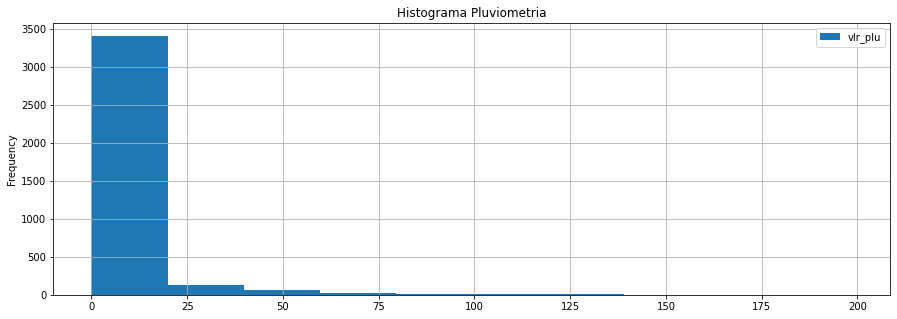

In [35]:
df_plu.plot(x='data_med', y='vlr_plu', kind='hist', figsize=(15,5), grid='True', title='Histograma Pluviometria');

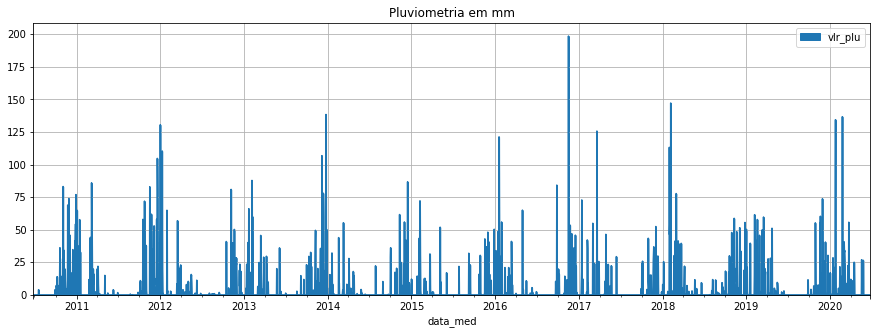

In [36]:
df_plu.plot(x='data_med', y='vlr_plu', kind='area', figsize=(15,5), grid='True', title='Pluviometria em mm');

In [37]:
del df_plu, cols, delta, end, i, j, start
gc.collect();

8302

# Continua....